# Obsah

> ## Úvod

> ## Knižnice

> ## Dataset

> ## Chýbajúce hodnoty

>> ### Zjednotenie formátov dát

>> ### Odvodenie chýbajúcich hodnôt po riadkoch

>> ### Doplnenie chýbajúcich hodnôt po stĺpcoch

> ## Vychýlené hodnoty

> ## Normalizácia údajov

> ## Transformácia numerických atribútov na kategorické

> ## Transformacia kategorických údajov na numerické

> ## Vytváranie atribútov kombinovanim

> ## Zdroje

## Doležité parametre
DecisionTreeClassifier(
criterion

max_depth=None

min_samples_leaf - počet pozorovani vo vyslednej podmnozine

class_weight=None

# Úvod
Na základe identifikovaných problémov v dátach a návrhu ich riešenia v predchádzajúcej fáze treba zrealizovať predspracovanie. Výsledkom by mala byť upravená dátová sada (vo formáte ​csv​) vo vhodnom tvare pre zvolený algoritmus strojového učenia (v našom prípade rozhodovacie stromy​). Zároveň, keďže predspracovaním sa mohol zmeniť tvar a charakteristiky dát (počet atribútov, distribúcie hodnôt a pod.), treba znovu zrealizovať podstatné časti prieskumnej analýzy, pričom v tejto fáze je potrebné zamerať sa aj na vzťahy medzi jednotlivými atribútmi.

# Knižnice

In [103]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")
from sklearn import preprocessing
from sklearn import linear_model
import datetime as dt

from fancyimpute import KNN

#regular expression
import re

#Nastavenie rozmerov zobrazovaných grafov
plt.rcParams['figure.figsize'] = 10, 7
from IPython.display import Image

#Integracia
from scipy.stats import boxcox
import scipy.stats as stats

# Func Defintions

In [2]:
def fixWierdCharsInString(string):
    if isinstance(string, float) or isinstance(string, int):
        return string
    if not isinstance(string, str): 
        return string
    if pd.isna(string) or string == '?' or string == '??':
        return np.nan
    #ocisti string od bielych znakov a regex: nahrad znaky [ -], za _
    return re.sub('[ -]','_', str.strip(string).upper())

In [3]:
def init_dataset(file):
    # Načítame si súbor s datasetom so separátom ',' a ako index nastavime prvý stĺpec
    data = pd.read_csv(file, sep=',', index_col=0)
    # Pomenujeme si index
    data.index.name = 'ID'
    # Ujednoti format nazvov stlpcov
    data = data.rename(columns=fixWierdCharsInString)
    print("Index name", data.index.name)
    print(data.columns)
    return data

In [4]:
def create_csv(df, file_name):
    df.to_csv(file_name, sep='\t')

In [5]:
def isNormalDistribution(data):
    z, pval = stats.normaltest(data)
    print(data.name, z, pval, True if pval > 0.05 else False)
    if(pval < 0.05):
        return print("Not normal distribution")

Na základe: http://mathforum.org/library/drmath/view/72065.html sme určili prahovú hodnotu kedy považujeme atribút za normálne rozdelenie

In [6]:
def checkAllObjectType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    for col_name in data.select_dtypes('object'):
        #Spočítame si pre každý "kategorický" atribút počet jeho jedinečných hodnôt
        print(col_name,":",data[col_name].nunique())  


In [7]:
def checkAllNumericType(data):
    #help(data.select_dtypes)
    #Selektneme si vsetky atribúty, ktoré majú nejasný dátový
    numeric_data = data.select_dtypes(['int64','float64'])
    for col_name in numeric_data.columns:
        #Spočítame si pre každý "Numerický" atribút počet jeho jedinečných hodnôt
        print(col_name,": modus:",numeric_data[col_name].mode(),", mean:", numeric_data[col_name].describe())
    numeric_data.apply(isNormalDistribution)

In [8]:
def convertToDateType(string):
    if pd.isna(string) or string == '??':
        return pd.NaT
    #Nastavime si datum na 10 znakov
    if isinstance(string, str):
        string = string.strip()[:10]
        if len(string) < 10:
            if(re.match("^[01][0-8]",string[:2])):
                print(string)
                string = '20'+ string
            elif(re.match("^[2-9][0-9]",string[:2])): 
                string = '19'+ string
                print(string)
    try: return pd.to_datetime(string, errors='raise')
    except ValueError:
            print(string)
            return pd.NaT

In [9]:
def fixWierdCharsInObjectType(data):
    forloop = {}
    for col in data.columns:
        data[col] = data[col].apply(fixWierdCharsInString)
        forloop[col] = data[col].value_counts(normalize=True).to_dict()
    return forloop

In [10]:
def calculateAgeFromDate(data, start_date):
    date = pd.to_datetime(start_date)
    data.loc[data[age_column].isna() & data[date_column].notna(), age_column] = (date - data.loc[(data[age_column].isna() & data[date_column].notna()), date_column]).astype('int64') 

In [11]:
def calculateDateFromAge(row):
    date = pd.to_datetime('2016-01-01')
    result_date = date.year - row['AGE']
    row['DATE_OF_BIRTH'] = pd.to_datetime(str(int(result_date)), errors='coerce')
    return row

In [12]:
def getFemaleSymbol():
    return 1

In [13]:
def getMaleSymbol():
    return 0

In [14]:
date = pd.to_datetime('2016-01-01')
result_date = date.year - 10.0
print(int(result_date))
pd.to_datetime(str(int(result_date)))

2006


Timestamp('2006-01-01 00:00:00')

In [15]:
def count_missing(data):
    null_data = pd.isnull(data)
    null_count = np.sum(null_data)
    return (null_count)

In [16]:
def prop_missing(data):
    num = count_missing(data)
    dem = data.size
    return num/dem

In [17]:
def prop_complete(data):
    return 1 - prop_missing(data)

# Dataset

In [18]:
#Inicializacia datasetu so zjednotenými nazvami
test_file = "data/zadanie4/test.csv"
test_data = init_dataset(test_file)

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')


In [19]:
train_file = "data/zadanie4/train.csv"
train_data = init_dataset(train_file)

Index name ID
Index(['AGE', 'SEX', 'ON_THYROXINE', 'QUERY_ON_THYROXINE',
       'ON_ANTITHYROID_MEDICATION', 'SICK', 'PREGNANT', 'THYROID_SURGERY',
       'I131_TREATMENT', 'QUERY_HYPOTHYROID', 'QUERY_HYPERTHYROID', 'LITHIUM',
       'GOITRE', 'TUMOR', 'HYPOPITUITARY', 'PSYCH', 'TSH_MEASURED', 'TSH',
       'T3_MEASURED', 'T3', 'TT4_MEASURED', 'TT4', 'T4U_MEASURED', 'T4U',
       'FTI_MEASURED', 'FTI', 'TBG_MEASURED', 'TBG', 'REFERRAL_SOURCE',
       'CLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION_NUM', 'RELATIONSHIP',
       'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'DATE_OF_BIRTH',
       'PERSONAL_INFO'],
      dtype='object')


In [20]:
#Aby sme mohli pracovat 
#data = train_data
data = train_data

# Zjednotenie formátov a typov dát

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2800 entries, 0 to 2799
Data columns (total 39 columns):
AGE                          2799 non-null float64
SEX                          2800 non-null object
ON_THYROXINE                 2800 non-null object
QUERY_ON_THYROXINE           2800 non-null object
ON_ANTITHYROID_MEDICATION    2800 non-null object
SICK                         2800 non-null object
PREGNANT                     2800 non-null object
THYROID_SURGERY              2800 non-null object
I131_TREATMENT               2800 non-null object
QUERY_HYPOTHYROID            2800 non-null object
QUERY_HYPERTHYROID           2800 non-null object
LITHIUM                      2800 non-null object
GOITRE                       2800 non-null object
TUMOR                        2800 non-null object
HYPOPITUITARY                2800 non-null object
PSYCH                        2800 non-null object
TSH_MEASURED                 2800 non-null object
TSH                          2516 non-null

In [22]:
checkAllObjectType(data)

SEX : 3
ON_THYROXINE : 6
QUERY_ON_THYROXINE : 2
ON_ANTITHYROID_MEDICATION : 2
SICK : 2
PREGNANT : 2
THYROID_SURGERY : 2
I131_TREATMENT : 2
QUERY_HYPOTHYROID : 2
QUERY_HYPERTHYROID : 2
LITHIUM : 2
GOITRE : 2
TUMOR : 2
HYPOPITUITARY : 2
PSYCH : 2
TSH_MEASURED : 2
T3_MEASURED : 2
TT4_MEASURED : 2
T4U_MEASURED : 2
FTI_MEASURED : 2
FTI : 210
TBG_MEASURED : 1
TBG : 1
REFERRAL_SOURCE : 5
CLASS : 2800
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 2456
PERSONAL_INFO : 700


Pre všetky vyššie atribúty nastavíme správny formát dát a prekonvertujeme na číselnú reprezentáciu, kvôli neskoršej klasifikácií.

In [23]:
#help(data.to_numeric)
#If ‘coerce’, then invalid parsing will be set as NaN
#FTI prekonvertujeme na čísla
column=fixWierdCharsInString('FTI')
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column].describe()

count    2505.000000
mean      110.787984
std        32.883986
min         2.000000
25%        93.000000
50%       107.000000
75%       124.000000
max       395.000000
Name: FTI, dtype: float64

Zmena hodnôt **M -> Male** a **F -> Female**, **? -> NaN**. 

In [24]:
#Nastavíme pohlavie na jeden formát
column = fixWierdCharsInString('sex')

data[column] = data[column].apply(fixWierdCharsInString)
data[column].replace(['F', 'M'], [getFemaleSymbol(), getMaleSymbol()], inplace=True)
#data[column] = data[column].fillna(-1)
data[column].value_counts()
#new_column = fixWierdCharsInString('sex_male')
#data = data.rename(columns={column:new_column})
#data.columns[1]

1.0    1830
0.0     860
Name: SEX, dtype: int64

Zmena hodnôt **f, F, FALSE -> False** a **t, T, TRUE -> True**

In [25]:
data.replace(['f', 'F', 'FALSE', 't', 'T', 'TRUE'], [False, False, False, True, True, True], inplace=True)

In [26]:
checkAllObjectType(data)

TBG : 1
REFERRAL_SOURCE : 5
CLASS : 2800
EDUCATION : 16
RELATIONSHIP : 9
DATE_OF_BIRTH : 2456
PERSONAL_INFO : 700


In [27]:
column = fixWierdCharsInString('relationship')
data[column].value_counts()

 Not-in-family     809
 Husband           550
 Unmarried         510
 Own-child         441
 Wife              253
 Not_in_family      95
 Other-relative     80
 Own_child          53
 Other_relative      9
Name: RELATIONSHIP, dtype: int64

Ujednotenie názvov v stĺpci **relationship**. 
Own-child -> Own_child
Not-in-family -> Not_in_family
Other-relative -> Other_relative

In [28]:
data[column] = data[column].apply(fixWierdCharsInString)
data[column].value_counts()

NOT_IN_FAMILY     904
HUSBAND           550
UNMARRIED         510
OWN_CHILD         494
WIFE              253
OTHER_RELATIVE     89
Name: RELATIONSHIP, dtype: int64

Ujednotenie formátu atribútu **date_of_birth**

In [29]:
column = fixWierdCharsInString('date_of_birth')
data[column] = data[column].apply(convertToDateType)
data[column].describe()

1979-12-12
1980-03-07
1960-09-14
1975-07-22
1958-02-03
1975-11-28
1948-10-06
1958-08-13
1967-08-21
1946-11-27
1953-02-24
1960-05-16
1976-07-05
1986-07-05
1938-11-23
1973-04-05
1978-09-04
1930-06-12
1981-09-17
1984-01-04
1990-02-01
1960-09-21
1992-11-09
1952-09-23
1963-06-17
1952-12-21
1973-04-17
1962-08-04
1971-02-24
1563-01-24
1957-03-07
1957-09-21
1969-10-17
1939-11-04
1979-10-04
1969-01-04
1987-02-01
1953-11-14
1965-09-15
1966-10-31
1952-06-25
1994-11-23
1945-05-12
1960-12-31
1985-11-21
1974-12-24
1974-06-25
1971-12-08
1992-08-22
1942-01-25
1935-07-15
1991-03-24
1941-08-08
1990-01-16
1964-12-07
1988-06-02
1967-09-01
1980-10-27
1995-01-15
1992-12-01
1968-09-26
1988-04-06
1944-03-05
1961-09-07
1989-04-12
1960-06-28
1981-05-04
1945-02-10
1994-05-04
1976-07-24
1958-02-13
1940-08-10
1944-04-15
1941-04-20
1962-11-18
1965-09-09
1942-08-17
1958-09-22
1961-10-04
1970-10-23
1938-11-29
1988-06-30
1981-07-09
1962-07-14
1952-10-09
1970-03-09
1994-06-21
1984-12-24
1955-02-02
1965-05-01
1957-08-19

count                    2519
unique                   2394
top       1957-08-19 00:00:00
freq                        3
first     1923-05-30 00:00:00
last      2016-11-03 00:00:00
Name: DATE_OF_BIRTH, dtype: object

Rozdelenie stĺpca **personal_info** do viacerých stĺpcov

In [30]:
column = fixWierdCharsInString('personal_info')
columns = list(map(fixWierdCharsInString, ['job','state', 'marital_status', 'job_segment', 'race']))
df_personal_data = pd.DataFrame(data[column].str.replace('\n','|').str.replace('--','|').str.split('|', expand=False).tolist(), columns=columns)
df_personal_data.head()

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,Other-service,United-States,Widowed,private,Black
1,Adm-clerical,United-States,Separated,Local-gov,White
2,Sales,United-States,Married-civ-spouse,private,White
3,Sales,United-States,Never-married,Private,Black
4,Adm-clerical,United-States,Never-married,Private,White


Atribút je teraz rozdelený do viacerých stĺpcov **job, state, parents_definition, segment, race**, ale je potrebné v nich urobiť nejaké úpravy. 

In [31]:
checkAllObjectType(df_personal_data)

JOB : 14
STATE : 37
MARITAL_STATUS : 7
JOB_SEGMENT : 15
RACE : 5


In [32]:
fixWierdCharsInObjectType(df_personal_data)

{'JOB': {'ADM_CLERICAL': 0.1654482493266641,
  'CRAFT_REPAIR': 0.07772220084647942,
  'EXEC_MANAGERIAL': 0.13659099653712967,
  'FARMING_FISHING': 0.021546748749519045,
  'HANDLERS_CLEANERS': 0.02308580223162755,
  'MACHINE_OP_INSPCT': 0.06156213928434013,
  'OTHER_SERVICE': 0.15390534821085033,
  'PRIV_HOUSE_SERV': 0.011158137745286649,
  'PROF_SPECIALTY': 0.14697960754136205,
  'PROTECTIVE_SERV': 0.019622931896883418,
  'SALES': 0.12158522508657175,
  'TECH_SUPPORT': 0.032320123124278566,
  'TRANSPORT_MOVING': 0.02847248941900731},
 'JOB_SEGMENT': {'?': 0.07107142857142858,
  'FEDERAL_GOV': 0.029285714285714286,
  'LOCAL_GOV': 0.07785714285714286,
  'NEVER_WORKED': 0.0007142857142857143,
  'PRIVATE': 0.6982142857142857,
  'SELF_EMP_INC': 0.024642857142857143,
  'SELF_EMP_NOT_INC': 0.055,
  'STATE_GOV': 0.04285714285714286,
  'WITHOUT_PAY': 0.00035714285714285714},
 'MARITAL_STATUS': {'DIVORCED': 0.18535714285714286,
  'MARRIED_AF_SPOUSE': 0.00035714285714285714,
  'MARRIED_CIV_SPOUSE

In [33]:
df_personal_data.head()

,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE
0,OTHER_SERVICE,UNITED_STATES,WIDOWED,PRIVATE,BLACK
1,ADM_CLERICAL,UNITED_STATES,SEPARATED,LOCAL_GOV,WHITE
2,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE
3,SALES,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK
4,ADM_CLERICAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE


Teraz môžeme vytvorené stĺpce z atribútu **personal_info** pripojiť k celému datasetu a vymazať atribút **personal_info**.

In [34]:
data = data.drop([column], axis=1) # vymazanie atribútu personal_info
data = data.join(df_personal_data)          # pridanie nových atribútov do nášho datasetu

Rozdelenie atribútu **class** do dvoch nových atribútov.

In [35]:
column = fixWierdCharsInString('class')
data[column].head()

ID
0    replacement therapy.|3560
1                negative.|311
2               negative.|3705
3               negative.|2668
4    replacement therapy.|1668
Name: CLASS, dtype: object

In [36]:
#data = train_data
#Nepotrebujeme
column2_name = 'second_id'
df_class = pd.DataFrame(data[column].str.split('\.\|').tolist(), columns = [column,column2_name])
df_class[column].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: CLASS, dtype: int64

In [37]:
# vymazanie atribútu class
data = data.drop([column], axis=1) 
# pridanie nových atribútov do nášho datasetu
data = data.join(df_class[column])
data[column].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: CLASS, dtype: int64

In [38]:
column = fixWierdCharsInString('education_num')
#data['education-num']
data[column] = pd.to_numeric(data[column], errors='coerce')
data[column] = data[column].apply(lambda x: abs(x)/100 if abs(x) > 100 else x)
data[column].value_counts()

9.0     894
10.0    670
13.0    437
14.0    138
11.0    130
12.0    103
7.0      97
6.0      79
8.0      54
4.0      45
15.0     42
5.0      41
16.0     25
3.0      24
2.0      17
1.0       4
Name: EDUCATION_NUM, dtype: int64

Vymazanie atribútu **TBG**, pretože atribút nenesie žiadnu zmysluplnú hodnotu a tým pádom nemá pre nás význam. 

In [39]:
column1 = fixWierdCharsInString('TBG')
column2 = fixWierdCharsInString('TBG_measured')
data = data.drop([column1], axis=1) 
data = data.drop([column2], axis=1) 

Atribútom **capital_gain** a **capital_loss** sme sa rozhodli ujednotiť dátové typy.

In [40]:
column = fixWierdCharsInString('capital_loss')
data[column] = data[column].astype('float64')

In [41]:
fixWierdCharsInObjectType(data)
checkAllObjectType(data)
data.select_dtypes('object').head()

REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 36
MARITAL_STATUS : 7
JOB_SEGMENT : 8
RACE : 5
CLASS : 4


,REFERRAL_SOURCE,EDUCATION,RELATIONSHIP,JOB,STATE,MARITAL_STATUS,JOB_SEGMENT,RACE,CLASS
ID,,,,,,,,,
0,OTHER,SOME_COLLEGE,UNMARRIED,OTHER_SERVICE,UNITED_STATES,WIDOWED,PRIVATE,BLACK,REPLACEMENT_THERAPY
1,OTHER,SOME_COLLEGE,UNMARRIED,ADM_CLERICAL,UNITED_STATES,SEPARATED,LOCAL_GOV,WHITE,NEGATIVE
2,OTHER,HS_GRAD,HUSBAND,SALES,UNITED_STATES,MARRIED_CIV_SPOUSE,PRIVATE,WHITE,NEGATIVE
3,OTHER,SOME_COLLEGE,OWN_CHILD,SALES,UNITED_STATES,NEVER_MARRIED,PRIVATE,BLACK,NEGATIVE
4,OTHER,ASSOC_VOC,OWN_CHILD,ADM_CLERICAL,UNITED_STATES,NEVER_MARRIED,PRIVATE,WHITE,REPLACEMENT_THERAPY


Po zjednotení formátov dát nám ostali len tieto atribúty s dátovým typom object. Kedže sa jedná o kategorické atribúty tak sme zatial spokojný s týmto dátovým typom.

# Chýbajúce hodnoty

In [42]:
import missingno as msno

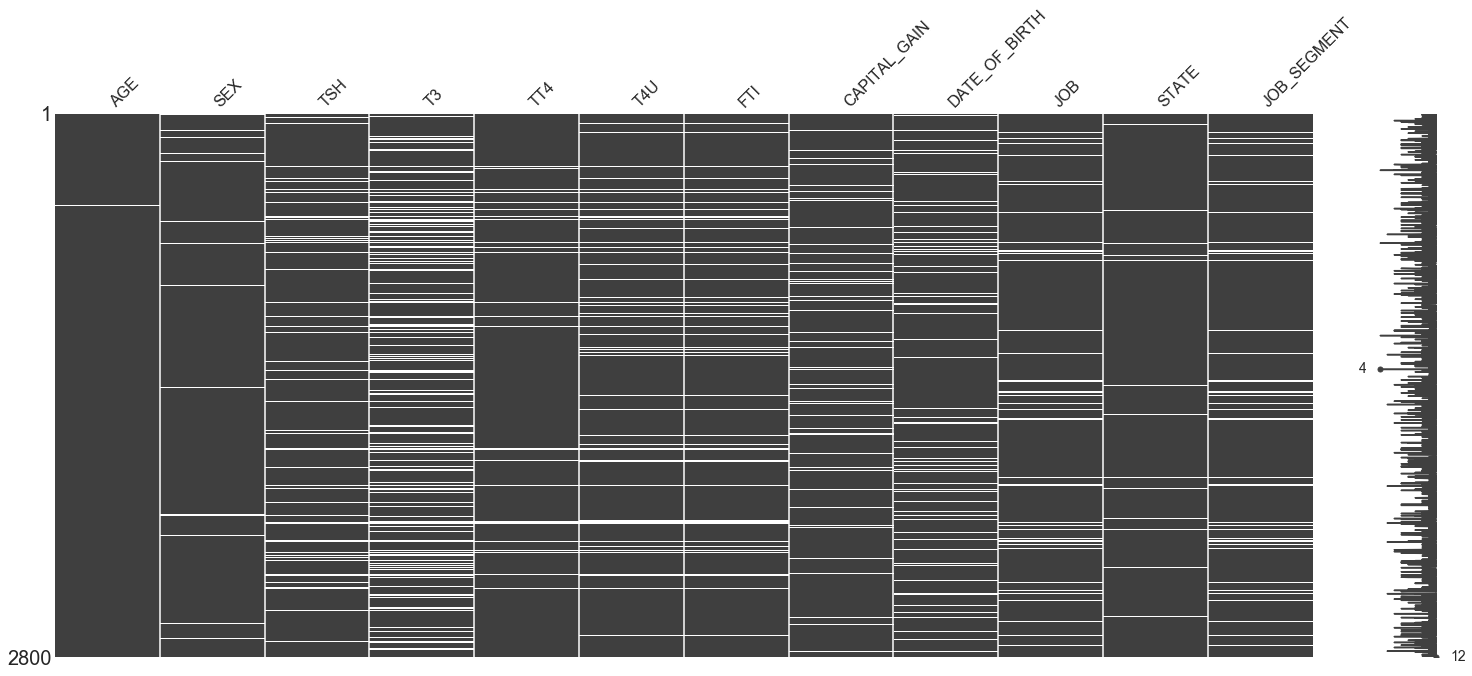

In [43]:
data.columns[data.isnull().any()].tolist()
msno.matrix(data[data.columns[data.isnull().any()].tolist()])

In [44]:
checkpoint_missing_data = data.copy()

Počty chýbajúcich hodnôt v jednotlivých atribútoch.http://scikit-learn.org/stable/data_transforms.html

In [45]:
data.apply(count_missing)

AGE                            1
SEX                          110
ON_THYROXINE                   0
QUERY_ON_THYROXINE             0
ON_ANTITHYROID_MEDICATION      0
SICK                           0
PREGNANT                       0
THYROID_SURGERY                0
I131_TREATMENT                 0
QUERY_HYPOTHYROID              0
QUERY_HYPERTHYROID             0
LITHIUM                        0
GOITRE                         0
TUMOR                          0
HYPOPITUITARY                  0
PSYCH                          0
TSH_MEASURED                   0
TSH                          284
T3_MEASURED                    0
T3                           585
TT4_MEASURED                   0
TT4                          184
T4U_MEASURED                   0
T4U                          297
FTI_MEASURED                   0
FTI                          295
REFERRAL_SOURCE                0
FNLWGT                         0
EDUCATION                      0
EDUCATION_NUM                  0
RELATIONSH

In [46]:
#Vypiseme si kolko missign values maju riadky. Takze napriklad 0 missing values ma 1634 pacinetov
data.apply(count_missing, axis=1).value_counts()

0    1446
1     684
2     356
5     117
3     105
4      52
6      28
7       8
8       4
dtype: int64

In [47]:
data.dropna(how="all").shape # môžeme vidieť, že žiadny riadok nie je taký, že má všetky hodnoty chýbajúce.

(2800, 41)

## Odvodenie chýbajúcich hodnôt po riadkoch

Pre atribút **sex** vieme chýbajúcu hodnotu zistiť napríklad z atribútu **pregnant** alebo z atribútu **relationship**

In [48]:
data['SEX'].isna().sum()

110

In [49]:
# Vyfiltrujeme si pacientov s nešpecifikovaným pohlavím, ktorí sú tehotní.
column = fixWierdCharsInString('sex')
help_column = fixWierdCharsInString('pregnant')
data.loc[(data[column].isna()) & (data[help_column]), column] = getFemaleSymbol()
#data[(data[column].isna()) & (data[help_column])] = 'F'

In [50]:
data['SEX'].isna().sum()

109

In [51]:
help_column = fixWierdCharsInString('relationship')
# Neexistuje v datasete muž/žena, ktorý/ktorá je vydatý/oženená.
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Wife'))].index, column] = getFemaleSymbol()
data.loc[data[data[column].isna() & (data[help_column] == fixWierdCharsInString('Husband'))].index, column] = getMaleSymbol()

In [52]:
data['SEX'].isna().sum()

61

In [53]:
# Vyfiltrujeme si pacientov s nešpecifikovaným datumom narodenia, a doplnime ich podla veku za predpokladu ze dataset bol robeni v roku 2016.
column = fixWierdCharsInString('date_of_birth')
help_column = fixWierdCharsInString('age')
data.loc[(data[column].isna()) & (data[help_column].notna()),[column, help_column]] = data.loc[(data[column].isna()) & (data[help_column].notna()),[column, help_column]].apply(calculateDateFromAge, axis=1)

In [54]:
data['DATE_OF_BIRTH'].isna().sum()

2

## Doplnenie chýbajúcich hodnôt po stĺpcoch

In [55]:
checkpoint_missing_data_by_columns = data.copy()

### Vytvorenie imputerov

In [56]:
imp_most_frequent = preprocessing.Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp_mean = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_median = preprocessing.Imputer(missing_values='NaN', strategy='median', axis=0)

In [57]:
checkAllObjectType(data)

REFERRAL_SOURCE : 5
EDUCATION : 16
RELATIONSHIP : 6
JOB : 13
STATE : 36
MARITAL_STATUS : 7
JOB_SEGMENT : 8
RACE : 5
CLASS : 4


Atribút **capital_gain** - chýbajúce hodnoty doplníme modusom, t.j. najčastejšie sa vyskytujúcou hodnotou.

In [58]:
column = fixWierdCharsInString('capital_gain')
mode = data[column].mode()
data[column] = pd.DataFrame(imp_most_frequent.fit_transform(data.loc[:,[column]]))

In [59]:
#Doplnime vsetky numericke pomocou imputer
#col_names = data.select_dtypes(exclude=['object', 'datetime64']).columns
#data.loc[:,col_names] = pd.DataFrame(imp_most_frequent.fit_transform(filled_numeric_data), columns=col_names)

In [60]:
data.apply(count_missing)

AGE                            1
SEX                           61
ON_THYROXINE                   0
QUERY_ON_THYROXINE             0
ON_ANTITHYROID_MEDICATION      0
SICK                           0
PREGNANT                       0
THYROID_SURGERY                0
I131_TREATMENT                 0
QUERY_HYPOTHYROID              0
QUERY_HYPERTHYROID             0
LITHIUM                        0
GOITRE                         0
TUMOR                          0
HYPOPITUITARY                  0
PSYCH                          0
TSH_MEASURED                   0
TSH                          284
T3_MEASURED                    0
T3                           585
TT4_MEASURED                   0
TT4                          184
T4U_MEASURED                   0
T4U                          297
FTI_MEASURED                   0
FTI                          295
REFERRAL_SOURCE                0
FNLWGT                         0
EDUCATION                      0
EDUCATION_NUM                  0
RELATIONSH

Polia, kde bola hodnota **'?'** sme prepísali na hodnotu **'Other_service'** z toho dôvodu, že tento atribút nevieme doplniť na základe žiadnej inej stratégie a preto sme priradili najvšeobecnejšiu hodnotu. 

In [61]:
column = fixWierdCharsInString('job')
data[column].isnull().sum()

201

In [62]:
general_value = fixWierdCharsInString('Other_service')
data[column].fillna(general_value, inplace=True)
data[column].isnull().sum()

0

Atribút **state** nahradíme modusom, pretože hodnota **'United_States'** sa nachádza u väčšiny pacientov a nevieme túto hodnotu doplniť pomocou iných atribútov. 

In [63]:
column = fixWierdCharsInString('state')
count_missing(data[column])

43

In [64]:
mode = data[column].mode()
data[column].fillna(mode[0], inplace=True)

In [65]:
count_missing(data[column])

0

In [66]:
data['JOB_SEGMENT'].value_counts()

PRIVATE             1955
LOCAL_GOV            218
SELF_EMP_NOT_INC     154
STATE_GOV            120
FEDERAL_GOV           82
SELF_EMP_INC          69
NEVER_WORKED           2
WITHOUT_PAY            1
Name: JOB_SEGMENT, dtype: int64

Chýbajúce hodnoty v atribúte **JOB_SEGMENT** sme doplnili pomocou najčastejšie sa vyskytujúcej hodnoty.

In [67]:
column = fixWierdCharsInString('job_segment')
mode = data[column].mode()
data[column].fillna(mode[0], inplace=True)

In [68]:
count_missing(data[column])

0

## TSH, T3, TT4, T4U, FTI

V týchto atribúte budeme dopĺňať chýbajúce hodnoty pomocou stratégie modus (most_frequent) a lineárnej regresie. Tieto dve stratégie potom porovnáme. 

In [69]:
col_names = ['TSH', 'T4U', 'T3', 'TT4', 'FTI']
for col in col_names:
     data[col] = pd.DataFrame(imp_most_frequent.fit_transform(data.loc[:, [col]]))

In [70]:
data.apply(count_missing)

AGE                           1
SEX                          61
ON_THYROXINE                  0
QUERY_ON_THYROXINE            0
ON_ANTITHYROID_MEDICATION     0
SICK                          0
PREGNANT                      0
THYROID_SURGERY               0
I131_TREATMENT                0
QUERY_HYPOTHYROID             0
QUERY_HYPERTHYROID            0
LITHIUM                       0
GOITRE                        0
TUMOR                         0
HYPOPITUITARY                 0
PSYCH                         0
TSH_MEASURED                  0
TSH                           0
T3_MEASURED                   0
T3                            0
TT4_MEASURED                  0
TT4                           0
T4U_MEASURED                  0
T4U                           0
FTI_MEASURED                  0
FTI                           0
REFERRAL_SOURCE               0
FNLWGT                        0
EDUCATION                     0
EDUCATION_NUM                 0
RELATIONSHIP                  0
CAPITAL_

### Metóda k najbližších susedov

In [71]:
##data = checkpoint_missing_data_by_columns.copy()
if count_missing(data[col_names]).sum() > 0:
    X_filled_knn = pd.DataFrame(KNN(k=3).complete(data[col_names]), columns=col_names)
    #Prirad pomocou KNN
    for col in col_names:
        data[col] = X_filled_knn[col]

In [72]:
data['SEX'].describe()

count    2739.000000
mean        0.670318
std         0.470184
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: SEX, dtype: float64

In [73]:
if count_missing(data['SEX']) > 0:
    X_filled_knn = pd.DataFrame(KNN(k=3).complete(data[['SEX']]), columns=['SEX'])
    data['SEX'] = X_filled_knn['SEX']

Imputing row 1/2800 with 0 missing, elapsed time: 0.788
Imputing row 101/2800 with 0 missing, elapsed time: 0.788
Imputing row 201/2800 with 0 missing, elapsed time: 0.789
Imputing row 301/2800 with 0 missing, elapsed time: 0.789
Imputing row 401/2800 with 0 missing, elapsed time: 0.790
Imputing row 501/2800 with 0 missing, elapsed time: 0.790
Imputing row 601/2800 with 0 missing, elapsed time: 0.791
Imputing row 701/2800 with 0 missing, elapsed time: 0.791
Imputing row 801/2800 with 0 missing, elapsed time: 0.792
Imputing row 901/2800 with 0 missing, elapsed time: 0.792
Imputing row 1001/2800 with 0 missing, elapsed time: 0.793
Imputing row 1101/2800 with 0 missing, elapsed time: 0.793
Imputing row 1201/2800 with 0 missing, elapsed time: 0.794
Imputing row 1301/2800 with 0 missing, elapsed time: 0.794
Imputing row 1401/2800 with 0 missing, elapsed time: 0.794
Imputing row 1501/2800 with 0 missing, elapsed time: 0.794
Imputing row 1601/2800 with 0 missing, elapsed time: 0.795
Imputing 

In [74]:
data.apply(count_missing)

AGE                          1
SEX                          0
ON_THYROXINE                 0
QUERY_ON_THYROXINE           0
ON_ANTITHYROID_MEDICATION    0
SICK                         0
PREGNANT                     0
THYROID_SURGERY              0
I131_TREATMENT               0
QUERY_HYPOTHYROID            0
QUERY_HYPERTHYROID           0
LITHIUM                      0
GOITRE                       0
TUMOR                        0
HYPOPITUITARY                0
PSYCH                        0
TSH_MEASURED                 0
TSH                          0
T3_MEASURED                  0
T3                           0
TT4_MEASURED                 0
TT4                          0
T4U_MEASURED                 0
T4U                          0
FTI_MEASURED                 0
FTI                          0
REFERRAL_SOURCE              0
FNLWGT                       0
EDUCATION                    0
EDUCATION_NUM                0
RELATIONSHIP                 0
CAPITAL_GAIN                 0
CAPITAL_

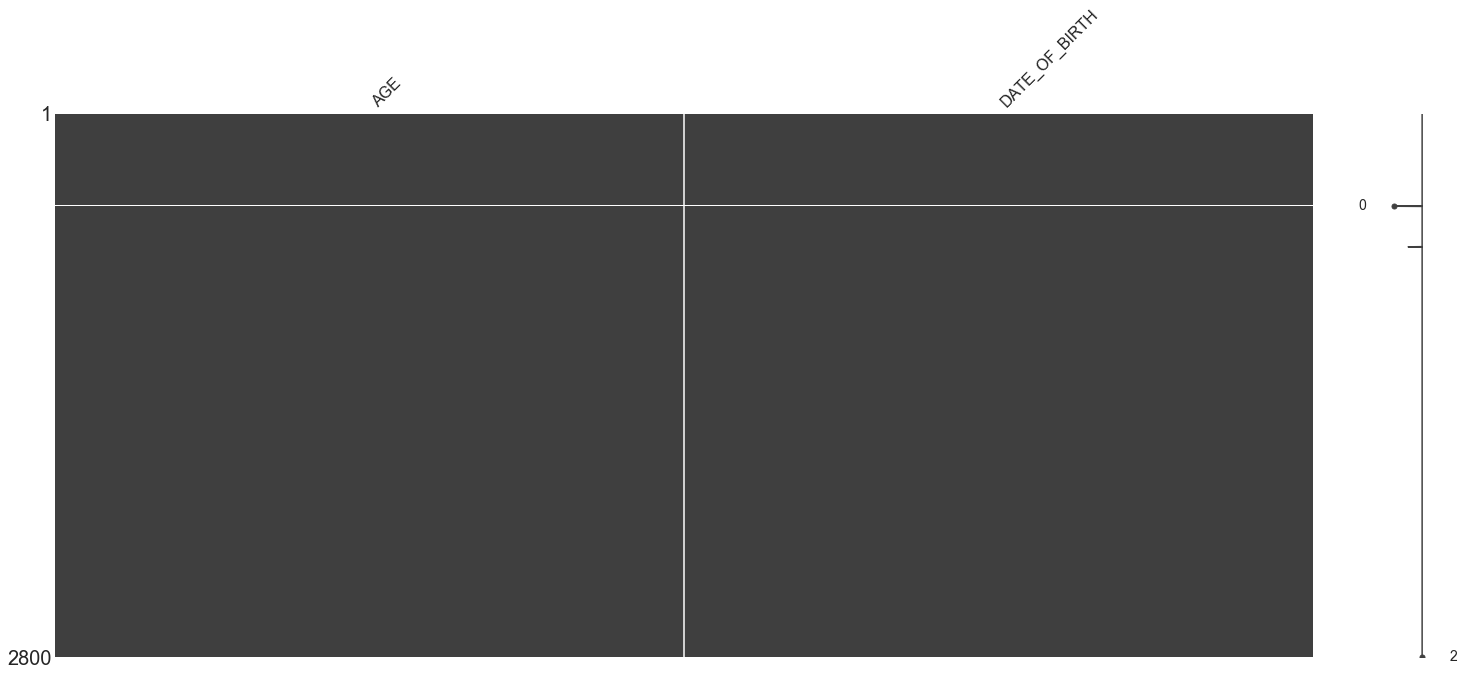

In [75]:
data.columns[data.isnull().any()].tolist()
msno.matrix(data[data.columns[data.isnull().any()].tolist()])

Kedže nám ostali dve neznáme hodnoty pre Vek a Dátum narodenia môžeme ich odstrániť alebo dopočítať ale zbytočne si môžeme zaniesť zlé dáta. Kedže sa jedná len o dvoch pacientov tak sme sa ich rozhodli odstrániť

In [76]:
data = data[data['DATE_OF_BIRTH'].notna()]

In [77]:
data.apply(count_missing)

AGE                          0
SEX                          0
ON_THYROXINE                 0
QUERY_ON_THYROXINE           0
ON_ANTITHYROID_MEDICATION    0
SICK                         0
PREGNANT                     0
THYROID_SURGERY              0
I131_TREATMENT               0
QUERY_HYPOTHYROID            0
QUERY_HYPERTHYROID           0
LITHIUM                      0
GOITRE                       0
TUMOR                        0
HYPOPITUITARY                0
PSYCH                        0
TSH_MEASURED                 0
TSH                          0
T3_MEASURED                  0
T3                           0
TT4_MEASURED                 0
TT4                          0
T4U_MEASURED                 0
T4U                          0
FTI_MEASURED                 0
FTI                          0
REFERRAL_SOURCE              0
FNLWGT                       0
EDUCATION                    0
EDUCATION_NUM                0
RELATIONSHIP                 0
CAPITAL_GAIN                 0
CAPITAL_

# Vychýlené hodnoty
V tejto časti sa snažíme spracovať vychýlené hodnoty numerických dát.

In [115]:
#vychylene_hodnoty_checkpoint = data.copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a39384390>,
      dtype=object)

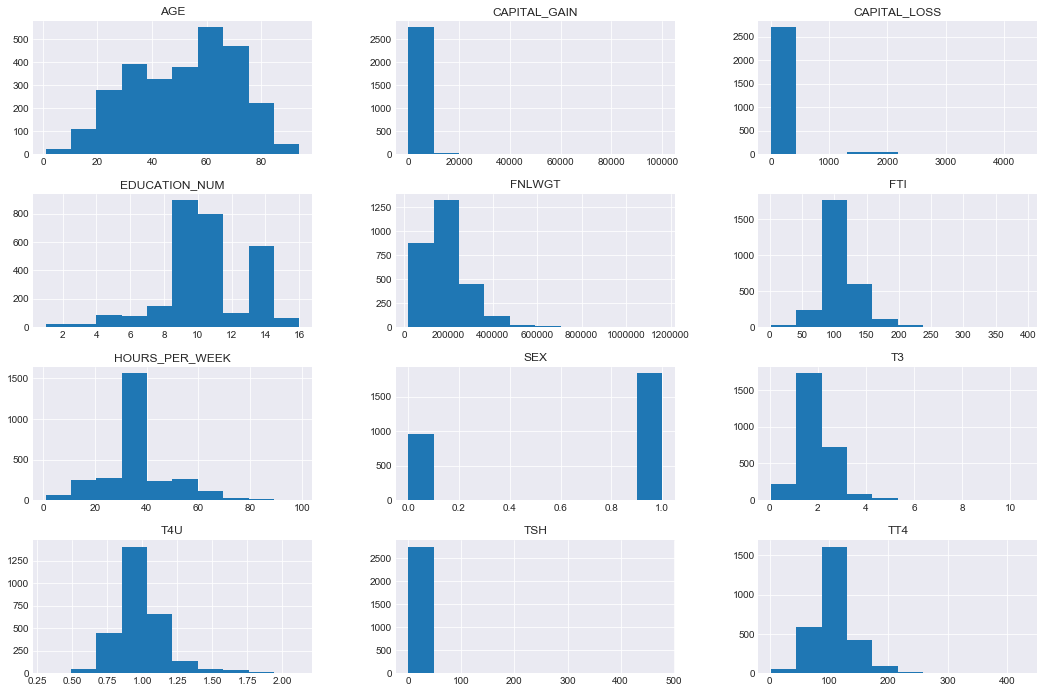

In [116]:
data.select_dtypes(exclude=['bool', 'object']).hist(figsize=(18, 12))

Vydíme že TSH nie je normálne rozdelenie a preto ho bude treba znormalizovat

In [123]:
column = fixWierdCharsInString('TSH')
data_for_plot[column] = data[column]
transformed, att = boxcox(data_for_plot[column])# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data

data_for_plot['BOXCOX_NORM'] = pd.DataFrame(transformed)

#pom = pd.Series(data_for_plot).hist(bins=50)
#pom.set_title("index: TSH")

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

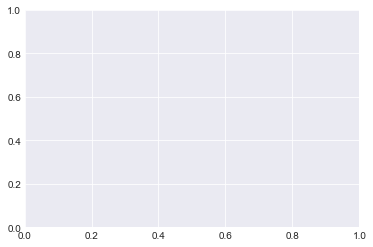

In [90]:
data_for_plot.hist()

In [ ]:
data_for_plot['BOXCOX_NORM'].plot.box()

Vydíme že TSH nie je normálne rozdelenie a preto ho bude treba znormalizovat

Atribút **age** odstránenie odchýlených hodnôt.

In [ ]:
data['AGE'].plot(kind="box")

Táto vychýlená hodnota vznikla pravdepodobne nesprávne odmeranými alebo vyplnenými údajmi. Skutočný vek tohto pacienta mohol byť napríklad 45 rokov, ale aj 55 rokov, no nevieme to zistiť tak sme sa rozhodli nahradiť hodnotu mediánom. 

In [ ]:
column = fixWierdCharsInString('age')
data.loc[(data[column] < 1) | (data[column] > 100), [column]] = data[column].median()
data['AGE'].plot(kind="box")

Ako iný spôsob odstránenia tejto vychýlenej hodnoty by sme mohli použiť nahradenie hornej vychýlenej hodnoty 95 percentilom a dolnej vychýlenej hodnoty 5 kvantilom. Takisto by sme mohli použiť aj metódu nahradenia medianom, pretože tento vek sa mohol pohybovať okolo 45, 55 rokov a to je približne median.

In [ ]:
#data.loc[(data[column] > 100), column] = data[column].quantile(0.95) 
#data.loc[(data[column] < 1), column] = data[column].quantile(0.05)
data['AGE'].mode()
data.info()

In [ ]:
col_names = ['TSH','T4U', 'T3', 'TT4', 'FTI']
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
data.loc[:,col_names].plot.box(color=color, sym='r+')

# Pomocné grafové examples

- data.fillna((0: 1, 1:1, 2:1))
- data.isnull().sum()
- data.dropna(how='all')
- data.plot.box()

In [ ]:
ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))

ts = ts.cumsum()
    
df = pd.DataFrame(np.random.randn(1000, 4), index=ts.index, columns=list('ABCD'))

df = df.cumsum()
df3 = pd.DataFrame(np.random.randn(1000, 2), columns=['B', 'C']).cumsum()

df3['A'] = pd.Series(list(range(len(df))))
df3.head()

In [ ]:
df.head(2)#.plot.hist(); plt.axhline(0, color='g')


In [ ]:
data.select_dtypes('int').plot.hist(alpha=0.5)

In [ ]:
df2 = pd.DataFrame(np.random.rand(10, 4), columns=['a', 'b', 'c', 'd'])

#df2.plot.bar(stacked=True);
plt.figure()
#data['AGE'].plot.bar()


In [ ]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000),'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])
plt.figure();

df4.plot.hist(alpha=0.5)

In [ ]:
df4.plot.hist(alpha=0.5, bins=200)

In [ ]:
plt.figure()
df['A'].head()

In [ ]:
df['A'].diff().head()

In [ ]:
df.diff().hist(color='k', alpha=0.5, bins=50)

In [ ]:
df = pd.DataFrame(np.random.rand(10, 5), columns=['A', 'B', 'C', 'D', 'E'])
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
df.plot.box(color=color, sym='r+', positions=[1, 4, 5, 6, 8])

In [ ]:
df.boxplot()

In [ ]:
df = pd.DataFrame(np.random.rand(10,2), columns=['Col1', 'Col2'] )

df['X'] = pd.Series(['A','A','A','A','A','B','B','B','B','B'])

plt.figure();
df
#bp = df.boxplot(by='X')

In [ ]:
np.random.seed(1234)
df_box = pd.DataFrame(np.random.randn(50, 2))
df_box['g'] = np.random.choice(['A', 'B'], size=50)
df_box.loc[df_box['g'] == 'B', 1] += 3
bp = df_box.boxplot(by='g')

In [ ]:
df = pd.DataFrame(np.random.rand(50, 4), columns=['a', 'b', 'c', 'd'])

In [ ]:
ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Group 1');

df.plot.scatter(x='c', y='d', color='DarkGreen', label='Group 2', ax=ax);

In [ ]:
df.plot.scatter(x='a', y='b', c='c', s=10);

# Zdroje
Príklady ako pracovať s pandas - https://pandas.pydata.org/pandas-docs/stable/cookbook.html#cookbook-plotting

Robenie grafov v pandas - https://pandas.pydata.org/pandas-docs/stable/visualization.html

# Manuálne podmienky vyhodnocovania

In [ ]:
seaborn.set_style("darkgrid")
columns = ['FTI', 'TT4', 'TSH', 'T3', 'T4U', 'CLASS', 'AGE']
lolo = data.loc[ : ,columns]
plot = seaborn.pairplot(lolo, x_vars=['TSH', 'T4U', 'T3', 'TT4', 'FTI'], y_vars='CLASS', size=5, aspect=0.7, hue='CLASS')


In [ ]:
columns = ['FTI', 'TT4', 'TSH', 'T3', 'T4U', 'CLASS']
lolo = data.loc[data['CLASS']!='NEGATIVE',columns]
g = seaborn.PairGrid(lolo, hue="CLASS", palette="Set2", hue_kws={"marker": ["o", "s", "D"]})
g = g.map(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.add_legend()

In [ ]:
def calculate_recall(tp, fn):
     return tp / (tp + fn)

def calculate_precision(tp, fp):
    return tp / (tp + fp)

def calculate_accuracy(tp, tn, fp, fn):
    return (tn + tp)/(tn + fp + fn + tp)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import recall_score, precision_score

In [ ]:
dataFrame = data.loc[:,['TSH', 'T4U', 'T3', 'TT4']]
dataFrame['FTI'] = pd.to_numeric(data['FTI'], errors='coerce')

column1_name = 'CLASS'

dataFrame['class'] = data['CLASS']
dataFrame = dataFrame.dropna()

seaborn.pairplot(dataFrame, dropna=True, hue='class')

Počet pacientov v jednotlivých triedach. 

In [ ]:
data['CLASS'].value_counts()

## Atribúty FTI, TT4, T3, T4U

Väčšina pacientov, ktorí majú hodnoty atribútov **FTI, TT4, T3, T4U** také, ako sú špecifikované, tak sú zdravý.

In [ ]:
df = data[(data['FTI'] < 71) | (data['TT4'] < 72) | (data['T3'] > 3.6) | (data['T4U'] > 1.34)]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

rel_all = data[((data['CLASS'] == 'NEGATIVE'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

fn = rel_all - tp
print(f"False negative: {fn}")

tn = data['CLASS'].count() - found_all - fn
print(f"True negative: {tn}")

Pokrytie (recall) daného pravidla

In [ ]:
calculate_recall(tp, fn)

Presnosť (precision) daného pravidla

In [ ]:
calculate_precision(tp, fp)

Accuracy daného pravidla

In [ ]:
calculate_accuracy(tp, tn, fp, fn)

Pri tejto podmienke sme sa snažili dovŕšiť čo najvyššiu presnosť vrátených dát, lebo určiť, že je pacient zdravý a pritom nie je, môže byť preňho kritické. 

### Rozpis jednotlivých atribútov (uvedieme len precision, pretože je prioritou)

In [ ]:
rel_all = data[((data['CLASS'] == 'NEGATIVE'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

### FTI

In [ ]:
df = data[(data['FTI'] < 71)]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

In [ ]:
calculate_precision(tp, fp)

### TT4

In [ ]:
df = data[(data['TT4'] < 72)]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

In [ ]:
calculate_precision(tp, fp)

### T3

In [ ]:
df = data[(data['T3'] > 3.6)]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

In [ ]:
calculate_precision(tp, fp)

### T4U

In [ ]:
df = data[(data['T4U'] > 1.36)]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

In [ ]:
calculate_precision(tp, fp)

## Kombinácie atribútov TSH, T3, FTI, T4U, TT4

In [ ]:
df = data[(data['TSH'] < 0.2) & (data['T4U'] < 0.8)]
df['CLASS'].value_counts()

In [ ]:
df = data[(data['TSH'] > 80) | ((data['TSH'] < 1) & (data['T3'] > 3.6)) | ((data['TSH'] > 40) & (data['TSH'] < 75))]
df['CLASS'].value_counts()

In [ ]:
df = data[(data['TSH'] < 37) & (data['T3'] > 3.4)]
df['CLASS'].value_counts()

V nasledujúcej vzorke sme zaznamenali, že nasledovné hodnoty atribútov zaznamenali skoro všetkých pacientov, ktorí majú hodnotu **UNDERREPLACEMENT**.

In [ ]:
df = data[(data['TSH'] > 5) & ((data['FTI'] > 63) & (data['FTI'] < 145))]
test = df['CLASS']
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

rel_all = data[((data['CLASS'] == 'UNDERREPLACEMENT'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

tp = df[df['CLASS'] == 'UNDERREPLACEMENT'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

fn = rel_all - tp
print(f"False negative: {fn}")

tn = data['CLASS'].count() - found_all - fn
print(f"True negative: {tn}")

Pokrytie (recall) daného pravidla

In [ ]:
calculate_recall(tp, fn)

Presnosť (precision) daného pravidla

In [ ]:
calculate_precision(tp, fp)

Accuracy daného pravidla

In [ ]:
calculate_accuracy(tp, tn, fp, fn)

Z pozorovania vidíme, že dosiahnuté pokrytie je veľmi vysoké a naopak, presnosť je veľmi nízka. Pri našich dátach je prioritou dosiahnuť vyššie pokrytie. 

V nasledujúcej vzorke sme zaznamenali, že nasledovné hodnoty atribútov zaznamenali väčšinu pacientov, ktorí majú hodnotu **OVERREPLACEMENT** alebo **REPLACEMENT_THERAPY**. Týmto pravidlom sme chceli vyselektovať pacientov, ktorí nie sú zdraví, teda patria do jednej z tried **OVERREPLACEMENT, REPLACEMENT_THERAPY**.

In [ ]:
df = data[(data['TSH'] < 1) & ((data['FTI'] > 155) & (data['FTI'] < 225))]
df['CLASS'].value_counts()

## Atribúty ON_ANTITHYROID_MEDICATION, I131_TREATMENT, LITHIUM, THYROID_SURGERY

Z nasledujúcej vzorky môžme povedať, že väčšina pacientov, ktorí boli na nejakej forme liečenia, alebo na operácii štítnej žlazy, tak sú zdravý.

In [ ]:
df = data[
    (data['ON_ANTITHYROID_MEDICATION'] == True) | # nejaká liečba štítnej žlazy
    (data['I131_TREATMENT'] == True) |    # liečba rádiojódom
    (data['LITHIUM'] == True) |    # užíval lithium
    (data['THYROID_SURGERY'] == True)   # operácia štítnej žlazy
]
df['CLASS'].value_counts()

In [ ]:
found_all = df['CLASS'].count()
print(f"Počet subjektov, ktoré nám naša podmienka našla: {found_all}")

rel_all = data[((data['CLASS'] == 'NEGATIVE'))].count()
rel_all = rel_all['CLASS']
rel_all
print(f"Počet subjektov, ktoré sme sa snažili identifikovať: {rel_all}")

tp = df[df['CLASS'] == 'NEGATIVE'].count()
tp = tp['CLASS']
print(f"True positive: {tp}")

fp = found_all - tp
print(f"False positive: {fp}")

fn = rel_all - tp
print(f"False negative: {fn}")

tn = data['CLASS'].count() - found_all - fn
print(f"True negative: {tn}")

Pokrytie (recall) daného pravidla

In [ ]:
calculate_recall(tp, fn)

Presnosť (precision) daného pravidla

In [ ]:
calculate_precision(tp, fp)

Accuracy daného pravidla

In [ ]:
calculate_accuracy(tp, tn, fp, fn)

Európania v našom datasete sú zdravý. (nič divné, kedže európania tvoria len veľmi malú časť datasetu).

In [ ]:
data['STATE'].value_counts()
df = data[(data['STATE'] == 'GERMANY') | 
          (data['STATE'] == 'POLAND') | 
          (data['STATE'] == 'ENGLAND') |
          (data['STATE'] == 'ENGLAND') |
          (data['STATE'] == 'ITALY') |
          (data['STATE'] == 'GREECE') | 
          (data['STATE'] == 'SCOTLAND') 
         ]
df['CLASS'].value_counts()

In [ ]:
data